In [1]:
import pywt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
X_range = np.arange(1000)      

def describe(signal):
    plt.figure(figsize=(16, 10))
    signal_with_noise = signal + np.random.normal(0, 1, len(signal))

    plt.subplot(3, 1, 1)
    plt.plot(signal_with_noise, 'gray', label='noised signal')
    plt.plot(signal, 'black', label='pure signal', linewidth=2)
    plt.xticks(()), plt.yticks(())
    plt.title('Signal')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(np.abs(np.fft.rfft(signal_with_noise)), 'black')
    plt.title('Fourier transform')
    plt.xticks(()), plt.yticks(())

    ax = plt.subplot(3, 1, 3)
    coef, freqs=pywt.cwt(signal ,np.arange(1, 120),'mexh')
    ax.matshow(coef, cmap='Greys')
    plt.title('Сontinuous wavelet transform')
    plt.xticks(()), plt.yticks(())
    plt.show()

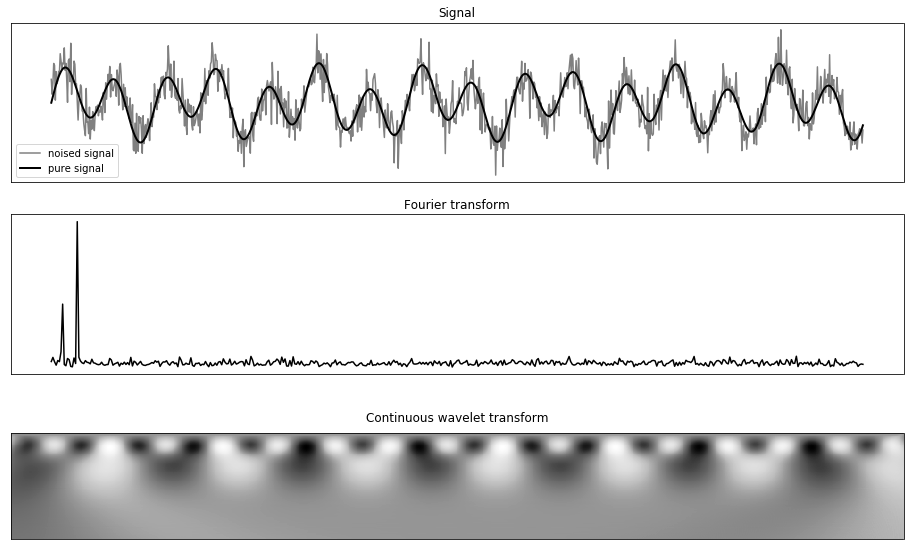

In [3]:
describe(np.sin(X_range / 23) + 2 * np.sin(X_range / 10))

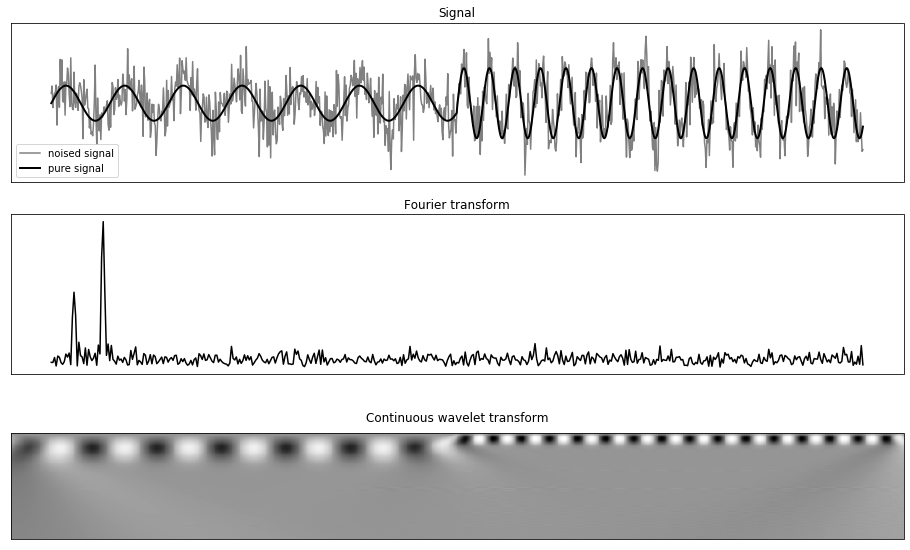

In [4]:
describe(np.append(np.sin(X_range[::2] / 23), 2 * np.sin(X_range[::2] / 10)))

In [5]:
from scipy import integrate

class wavelet_series:
    def __init__(self, g, levels=8):
        self.levels = levels
        mother_wavelet = lambda x: 0 if x < 0 else 1 if x < 0.5 else -1 if x < 1 else 0

        self.scaling = lambda x: 1 if 0 <= x < 1 else 0

        self.basis = [[
                (lambda i, j: lambda x: 2 ** (i / 2) * mother_wavelet(2**i * x - j))(i, j)
            for j in range(2 ** i)] for i in range(levels)]

        self.coef = [[
                integrate.quad(lambda x: g(x) * self.basis[i][j](x), 0, 1)[0] 
            for j in range(2 ** i)] for i in range(levels)]

        self.scaling_coef = integrate.quad(
            lambda x: g(x) * self.scaling(x), 0, 1)[0]
        
    def __call__(self, point):
        value = 0
        for i in range(self.levels):
            for j in range(2 ** i):
                value += self.coef[i][j] * self.basis[i][j](point)
        return value + self.scaling_coef * self.scaling(point)

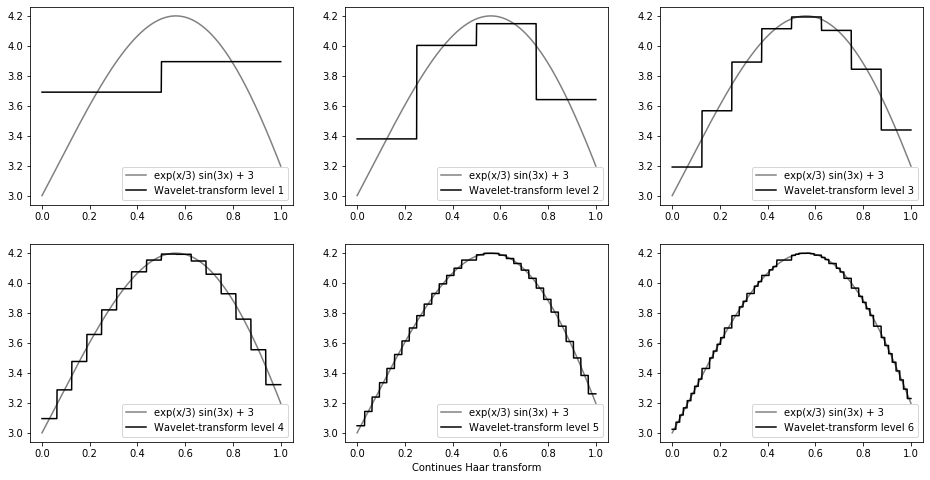

In [6]:
g = lambda x: np.exp(x / 3) * np.sin(3 * x) + 3
xs = np.linspace(1e-8, 1 - 1e-8, 1000)

plt.figure(figsize=(16, 8))

for i in range(1, 7):
    f = wavelet_series(g, i)
    plt.subplot(2, 3, i)
    plt.plot(xs, list(map(g, xs)), 'grey', label='exp(x/3) sin(3x) + 3')
    plt.plot(xs, list(map(f, xs)), 'black', label='Wavelet-transform level %d' % i)
    plt.legend()
    
    if i == 5:
        plt.xlabel('Continues Haar transform')

plt.show()

In [7]:
def decomposition(signal, wavelet='Haar'):
    wavelet = pywt.Wavelet(wavelet)
    signal_with_noise = signal + np.random.normal(0, 0.2, len(signal))

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plt.plot(signal, 'black', label='pure signal')
    plt.plot(signal_with_noise,'gray', label='noised signal', linewidth=0.5)
    plt.legend()

    coefs = pywt.wavedec(signal_with_noise, wavelet, level=8)
   
    plt.subplot(2, 2, 2)
    plt.plot(pywt.waverec(coefs, wavelet), 'black', label='Full recovery (8 levels)', linewidth=0.5)
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(pywt.waverec(coefs[:-2], wavelet), 'black', label='6 levels recovery', linewidth=0.5)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(pywt.waverec(coefs[:-5], wavelet), 'black', label='3 levels recovery', linewidth=0.5)
    plt.legend()
    
    plt.show()

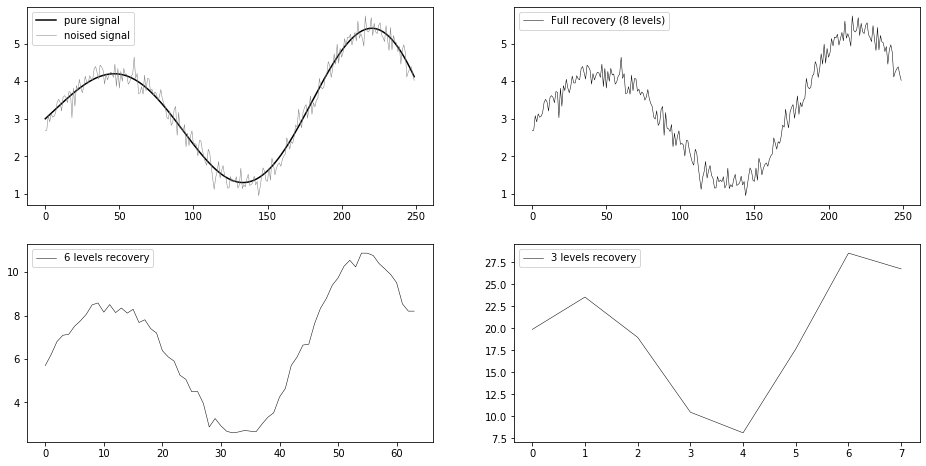

In [8]:
decomposition(g(np.linspace(0, 3, 250)))

In [33]:
def ShowSeries(series, wavelet='mexh'):
    test = sm.tsa.adfuller(series)
    
    plt.figure(figsize=(16, 3))
    plt.plot(series, 'Grey', linewidth=0.5)
    plt.xticks(())
    plt.yticks(())
    if test[0] > test[4]['5%']: 
        plt.title('Non-stationary series by Dickey-Fuller test')
    else:
        plt.title('Stationary series by Dickey-Fuller test')
        
    coef, freqs = pywt.cwt(series ,np.arange(1, 200), wavelet)
    plt.matshow(coef, cmap='Greys')
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])

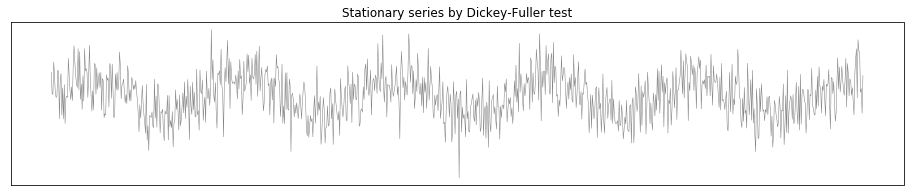

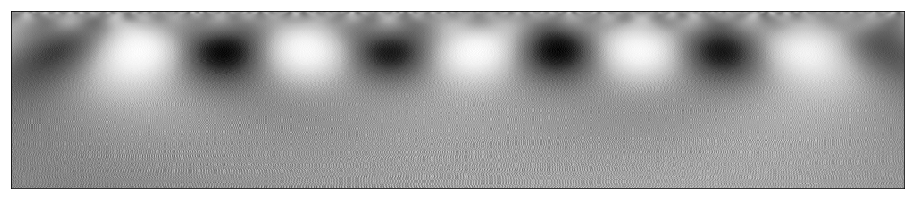

adf:  -3.271126738422732
p-value:  0.016219485710013207
Critical values:  {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}


In [34]:
noise = np.random.normal(0, 1, 1000)
x_range = np.arange(1000)

ShowSeries(np.sin(x_range / 30) + noise)

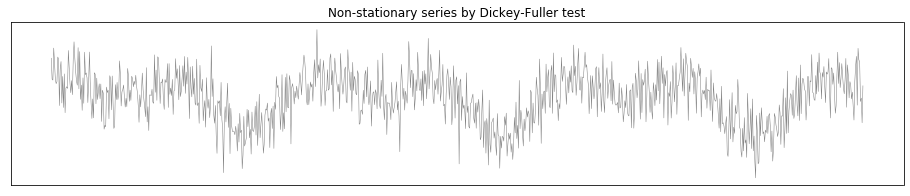

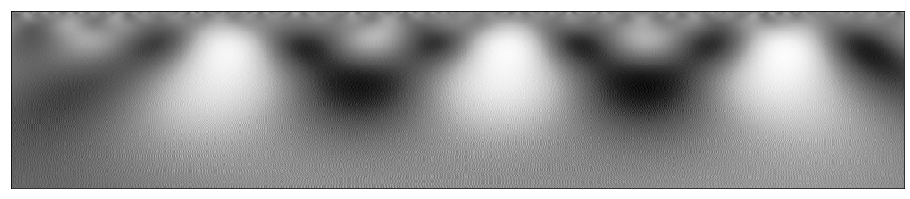

adf:  -2.7898387128197286
p-value:  0.0597399591879686
Critical values:  {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}


In [35]:
ShowSeries(np.sin(x_range / 50) + np.sin(x_range / 25 - 5) + noise)

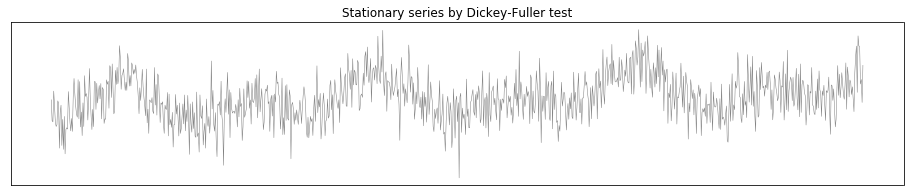

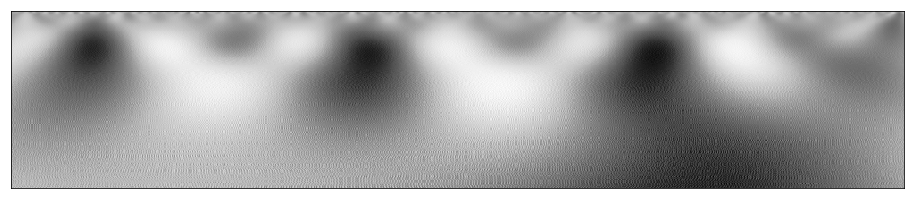

adf:  -2.9032664749673907
p-value:  0.04496946730846122
Critical values:  {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}


In [36]:
ShowSeries(np.sin(x_range / 50) + np.sin(x_range / 25 - 2) + x_range / 500 + noise * 1.3)

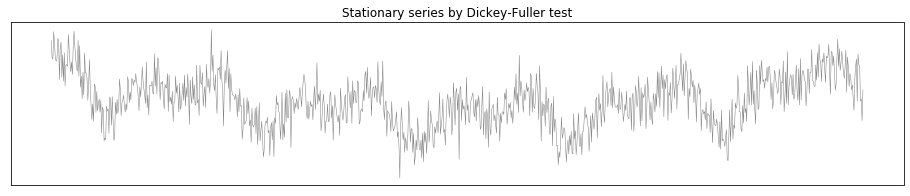

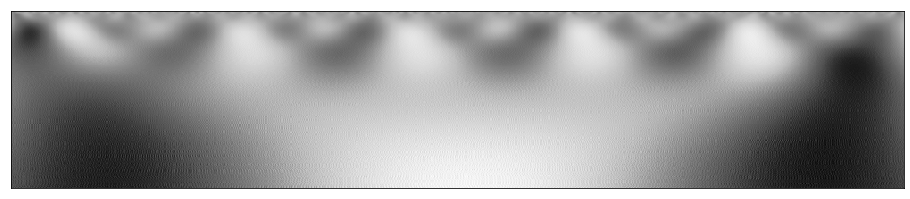

adf:  -3.3904144876681777
p-value:  0.011290013771991118
Critical values:  {'1%': -3.436972562223603, '5%': -2.864463856182476, '10%': -2.5683268054280175}


In [37]:
ShowSeries(np.sin(x_range / 30 + 2) + np.sin(x_range / 15) 
           + ((x_range - len(x_range) / 2) / 300)**2 + noise)

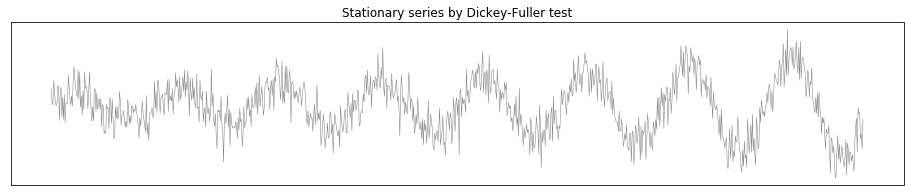

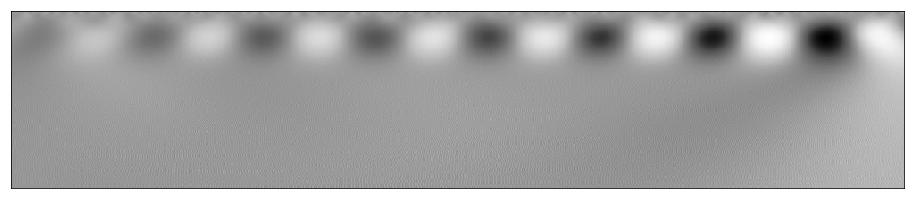

adf:  -6.009258825005522
p-value:  1.587893365748569e-07
Critical values:  {'1%': -3.437054035425408, '5%': -2.8644997864059363, '10%': -2.5683459429326576}


In [38]:
ShowSeries((np.sin(x_range / 20)) * (x_range + len(x_range))**2 + noise * 1e6)

In [15]:
df = pd.read_csv('nss15.csv')

time = pd.to_datetime(df.treatmentDate, format='%m/%d/%Y')
timeseries = pd.Series(np.ones(len(time)), index=sorted(time), dtype=np.int64).resample('D').sum()

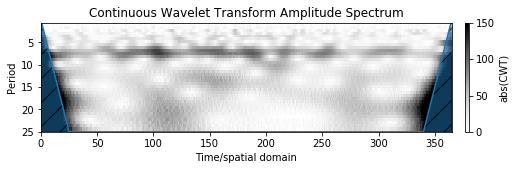

In [22]:
from scaleogram import cws

cws(timeseries, cmap='Greys', clim=[0, 150], figsize=(8, 2))
plt.show()

In [17]:
timeseries.index = pd.Series(timeseries.index).apply(lambda day: day.weekday())

In [40]:
dayweeks = ['понедельник', 'вторник', 'среду', 'четверг', 'пятницу', 'субботу', 'воскресенье']

for i in range(7):
    print('В {:12s}: {} случаев'.format(dayweeks[i], timeseries[i].sum()))
    
for i in range(7):
    print('В {:12s}: {} случаев'.format(dayweeks[i], round(timeseries[i].mean())))

В понедельник : 49868 случаев
В вторник     : 46629 случаев
В среду       : 46727 случаев
В четверг     : 46798 случаев
В пятницу     : 45269 случаев
В субботу     : 49408 случаев
В воскресенье : 50140 случаев
В понедельник : 959.0 случаев
В вторник     : 897.0 случаев
В среду       : 899.0 случаев
В четверг     : 883.0 случаев
В пятницу     : 871.0 случаев
В субботу     : 950.0 случаев
В воскресенье : 964.0 случаев


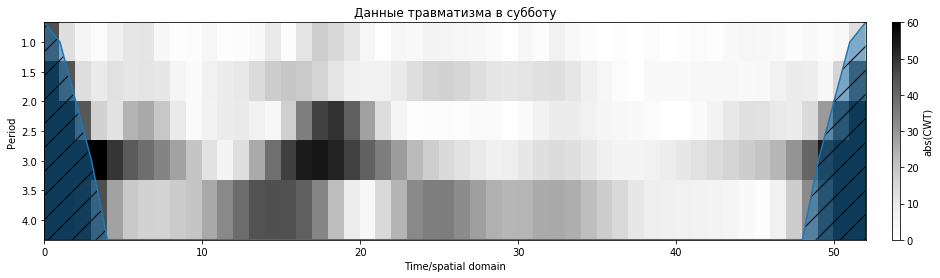

In [21]:
plt.figure(figsize=(16, 16), dpi=600)

for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    cws(timeseries[i], cmap='Greys', ax=ax, clim=[0, 60], title='Данные травматизма в %s' % dayweeks[i])
plt.show()

plt.figure(figsize=(16, 4))
ax = plt.subplot(1, 1, 1)
cws(timeseries[6], cmap='Greys', ax=ax, clim=[0, 60], title='Данные травматизма в %s' % dayweeks[i])
plt.show()